# Feature Generation

Plan: for each day `t`, generate a feature set with:
* [1] Day index: monday=0, sunday=6
* [7] Day index (one-hot)
* [2] is_weekday/is_weekend (one-hot)
* [4] CashIn/CashOut averages of the last week/month
* [3] Offset of paydays: 1st and 15th of the current month, 1st of the next month
* [2] Trend: Find difference between the t-7 and t-14, add the difference to t-7
* [2] is_kurban/is_ramazan: whether the date is inside the period of the holiday
* [2] kurban_in_7_days/ramazan_in_7_days: whether the holiday is closer than 7 days
* [28] Last 14 days of CashIn and CashOut `(t-1)` to `(t-14)`

In [1]:
from feature_generation import *

import matplotlib.pyplot as plt
import pandas as pd

C:\Users\cahid\anaconda3\envs\arute\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\cahid\anaconda3\envs\arute\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\cahid\anaconda3\envs\arute\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
df = pd.read_csv("DATA_sample_atm.csv")
means = df.groupby("HistoryDate").mean()[['CashIn','CashOut']]
means = means[:-35]
means = clean_data(means)

In [3]:
feature_set = get_feature_sets(means, ['CashIn', 'CashOut'])
feature_set.columns

Index(['CashIn', 'CashOut', 'Day_Index', 'Day_0', 'Day_1', 'Day_2', 'Day_3',
       'Day_4', 'Day_5', 'Day_6', 'Is_Weekday', 'Is_Weekend',
       'CashIn_average_7', 'CashIn_average_30', 'CashOut_average_7',
       'CashOut_average_30', 'curr_month_1_delta', 'curr_month_15_delta',
       'next_month_1_delta', 'CashIn_trend_7', 'CashOut_trend_7', 'is_ramazan',
       'ramazan_in_7_days', 'is_kurban', 'kurban_in_7_days', 'CashIn_t-1',
       'CashIn_t-2', 'CashIn_t-3', 'CashIn_t-4', 'CashIn_t-5', 'CashIn_t-6',
       'CashIn_t-7', 'CashIn_t-8', 'CashIn_t-9', 'CashIn_t-10', 'CashIn_t-11',
       'CashIn_t-12', 'CashIn_t-13', 'CashIn_t-14', 'CashOut_t-1',
       'CashOut_t-2', 'CashOut_t-3', 'CashOut_t-4', 'CashOut_t-5',
       'CashOut_t-6', 'CashOut_t-7', 'CashOut_t-8', 'CashOut_t-9',
       'CashOut_t-10', 'CashOut_t-11', 'CashOut_t-12', 'CashOut_t-13',
       'CashOut_t-14', 'CashOut_t-15', 'CashOut_t-16', 'CashOut_t-17',
       'CashOut_t-18', 'CashOut_t-19', 'CashOut_t-20', 'CashOut_

In [4]:
feature_set.head()

,CashIn,CashOut,Day_Index,Day_0,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,...,CashOut_t-31,CashOut_t-32,CashOut_t-33,CashOut_t-34,CashOut_t-35,CashOut_t-36,CashOut_t-37,CashOut_t-38,CashOut_t-39,CashOut_t-40
HistoryDate,,,,,,,,,,,,,,,,,,,,,
2016-02-10,41271.000000,43044.516949,2,0,0,1,0,0,0,0,...,20521.749571,33242.343348,43740.910653,37534.725086,45121.282272,52577.523727,39836.343993,16629.013453,23876.908432,23631.737089
2016-02-11,42509.389831,34889.915254,3,0,0,0,1,0,0,0,...,38354.708405,20521.749571,33242.343348,43740.910653,37534.725086,45121.282272,52577.523727,39836.343993,16629.013453,23876.908432
2016-02-12,37413.412362,35142.133785,4,0,0,0,0,1,0,0,...,32799.991431,38354.708405,20521.749571,33242.343348,43740.910653,37534.725086,45121.282272,52577.523727,39836.343993,16629.013453
2016-02-13,28132.895851,30029.305673,5,0,0,0,0,0,1,0,...,28441.979434,32799.991431,38354.708405,20521.749571,33242.343348,43740.910653,37534.725086,45121.282272,52577.523727,39836.343993
2016-02-14,20353.607113,19703.801863,6,0,0,0,0,0,0,1,...,29305.484147,28441.979434,32799.991431,38354.708405,20521.749571,33242.343348,43740.910653,37534.725086,45121.282272,52577.523727


### Correlation between the generated features:

In [5]:
def correlation(feature_set, correlation_with=None):
    if correlation_with != None:
        drop_column = "CashIn" if correlation_with == "CashOut" else "CashOut"
        feature_set = feature_set[feature_set.drop(columns=drop_column).columns]
        title = "Correlation with " + correlation_with
    else:
        title = "Correlation matrix"
    corrs = feature_set.corr()

    plt.figure(figsize=(10,10))
    plt.gca().invert_yaxis()

    # https://matplotlib.org/stable/tutorials/colors/colormaps.html
    plt.pcolor(corrs, cmap = "Greens")
    plt.yticks(np.arange(0.5, len(corrs.index), 1), corrs.index)
    plt.xticks(np.arange(0.5, len(corrs.columns), 1), corrs.columns, rotation = 'vertical')
    plt.title(title)
    plt.show()

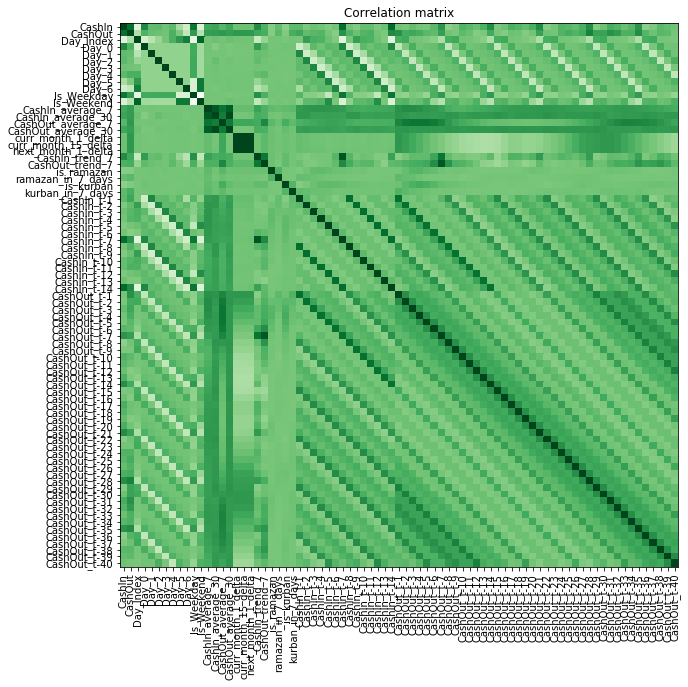

In [6]:
correlation(feature_set)

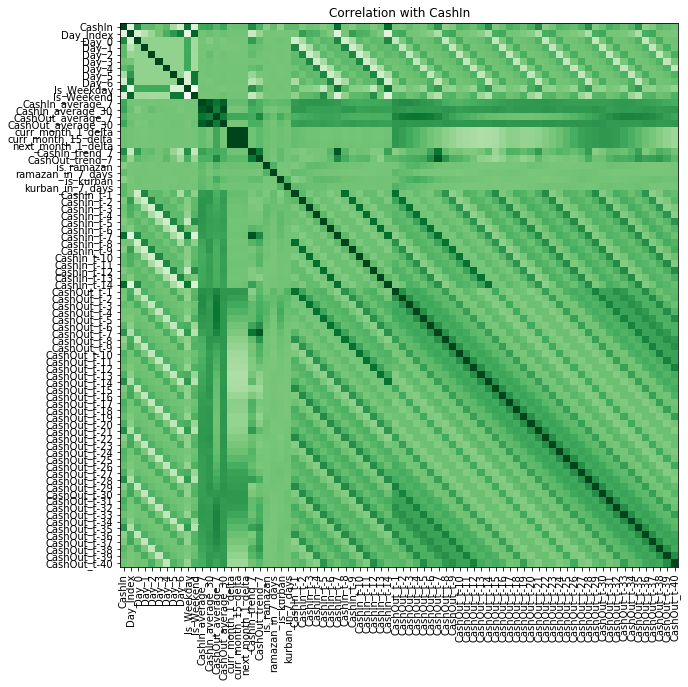

In [7]:
correlation(feature_set, 'CashIn')

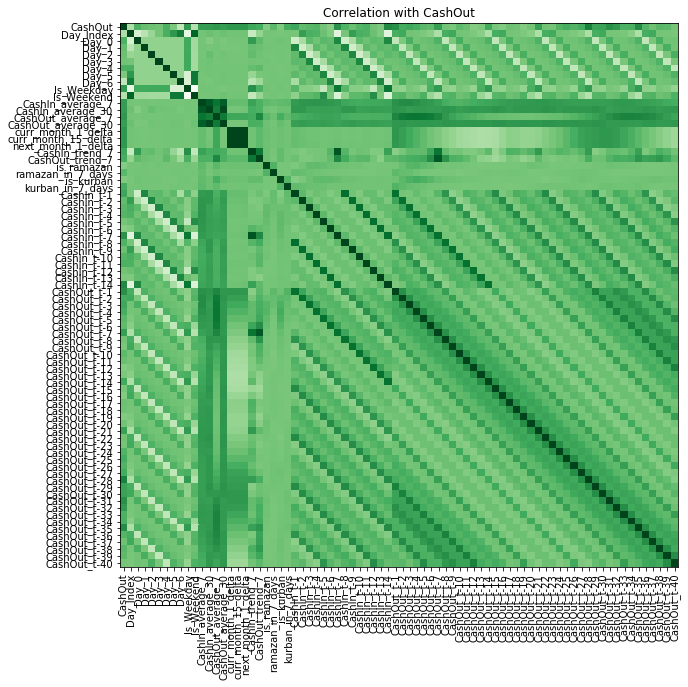

In [8]:
correlation(feature_set, 'CashOut')

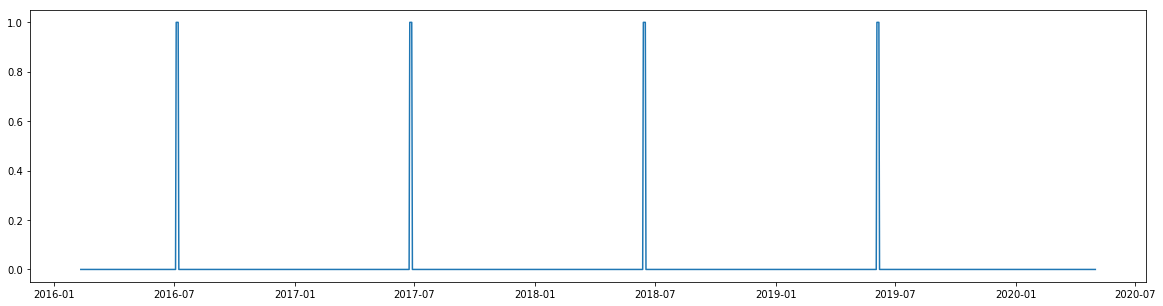

In [9]:
plt.figure(figsize=(20,5))
plt.plot(feature_set['is_ramazan'])